In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import pandas as pd

In [185]:
methods = ["MMD", "MMD OCSVM Verify", "OCSVM"]
model_types = {"kernel=\'linear\'" : "linear", "SVR(":"non-linear", "LinearRegression" : "LReg"}
kernel_colors = {"linear" : "r", "non-linear" : "b", "LReg" : "o", "combined" : "g"}
colors = ["bo", "go", "ro", "co", "mo", "yo", "ko"]
direction_markers = [">", "<"]
marker_meaning = {">" : "forward", "<" : "backwards"}
normalized = {True : "-std", False: ""}
alpha_norm = {True : 1/3, False: 2/3}

In [164]:
def sort_similar_pairs(df):
    n_pairs =  int(df.shape[0]/2)
    
    for pair_index in range(n_pairs):
        pair = df.iloc[pair_index*2].copy()
        backwards_pair =  df.loc[(df.test_node == pair.model_node) & 
                                (df.model_node == pair.test_node)]

        if pair_index*2+1 != backwards_pair.index:
            misplaced_pair = df.loc[pair_index*2+1]
            df.iloc[backwards_pair.index] = misplaced_pair
            df.iloc[pair_index*2+1] = backwards_pair

        if pair.model_node > pair.test_node:
            df.iloc[pair_index*2] = backwards_pair
            df.iloc[pair_index*2+1] = pair

    similar_pairs = [pair for pair in df.values]
    
    return similar_pairs

def get_pair_df(pair, df):
    forward_match = ((df.model_node==pair[0])&(df.test_node==pair[1]))
    backward_match = ((df.model_node==pair[1])&(df.test_node==pair[0]))
    regex_model_types = "|".join(["kernel=\'linear\'", "SVR"])
    model_type_match = (df.model.str.contains(regex_model_types, regex=True))
    pair_df = df.loc[(forward_match|backward_match) & (model_type_match)]
    return pair_df

def get_linear_non_linear_df(df):
    df_linear = df.loc[df.model.str.contains("kernel=\'linear\'")]
    df_non_linear = pd.concat([df,df_linear]).drop_duplicates(keep=False)
    return df_linear, df_non_linear

In [202]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def plot_r2_discrpenacy(data, omit_bad_pairs=False):
    stats = {}
        
    for experiment in range(1,4):
        experiment_stats = pd.DataFrame(columns = data.discrepancy.describe().index)
        df = data.loc[(data.experiment==experiment)]
        unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False)))     
        similar_pairs = sort_similar_pairs(unique_pairs_df)
        pair_dfs = {str((pair[0], pair[1])): get_pair_df(pair, df) for pair in similar_pairs[::2]}
        
        if omit_bad_pairs:
            pair_dfs = {pair: pair_df for pair, pair_df in pair_dfs.items() if pair_df.discrepancy.min()<1}
        
        n_pairs = len(pair_dfs)

        fig, axs = plt.subplots(nrows = n_pairs, ncols = 3, sharey="col", figsize= (12, n_pairs * 3))
        fig.suptitle("Experiment "+ str(experiment), fontsize =15)
        fig.tight_layout(pad=3.0)
        
        xlabel = "Discrepancy"
        ylabel = "Coefficient of Determination"
        
        if n_pairs > 1:
            pair_index=0
        
        
        for pair, pair_df in pair_dfs.items():     
            for row in pair_df.loc[pair_df.method == pd.unique(pair_df.method)[0]].itertuples(index=False):
                model_type = [model_types[m] for m in model_types if m in row.model][0]
                color = kernel_colors[model_type]
                x, y = row.discrepancy, row.score

                if row.model_node < row.test_node:
                    direction = 0
                else:
                    direction = 1 
                args = [color, alpha_norm[row.std], direction_markers[direction]]

                if n_pairs == 1:
                    axs[1].plot(x, y, args[0], alpha = args[1], marker = args[2])
                else:
                    axs[pair_index,1].plot(x, y, args[0], alpha = args[1], marker = args[2])

            threshold = pair_df.loc[pair_df.method=="OCSVM"].threshold.values[0]
            pair_methods = ", ".join([f"{method}({threshold})" if method != "MMD" else method 
                                     for method in pd.unique(pair_df.method)])
            
            title = f"{pair}-({pair_methods})"

            
            forward = pair_df.loc[pair_df.model_node < pair_df.test_node]
            backward = pair_df.loc[pair_df.model_node > pair_df.test_node]
            backward_pair = str((backward.model_node.values[0], backward.test_node.values[0]))
            
            forward_linear, forward_non_linear = get_linear_non_linear_df(forward)
            backward_linear, backward_non_linear = get_linear_non_linear_df(backward)
            
            experiment_stats.loc[pair] = forward.discrepancy.describe().values.T
            experiment_stats.loc[backward_pair] = backward.discrepancy.describe().values.T
            
            if n_pairs == 1:
                axs[0].set_title(pair, fontsize=10)
                axs[1].set_title(title, fontsize=10)
                axs[2].set_title(backward_pair, fontsize=10)
                
                [axs[i].set_xlabel(xlabel) for i in range(3)]
                axs[1].set_ylabel(ylabel)
                if omit_bad_pairs:
                    axs[1].set_xlim([0,1.0])
                    
                axs[0].hist(forward.discrepancy, bins = 4, color="g", alpha=2/3)
                axs[2].hist(backward.discrepancy, bins = 4, color="g", alpha=2/3)
                
                axs[0].hist(forward_linear.discrepancy, bins = 4, color="r", alpha=2/3)
                axs[0].hist(forward_non_linear.discrepancy, bins = 4, color="b", alpha=2/3)
                
                axs[2].hist(backward_linear.discrepancy, bins = 4, color="r", alpha=2/3)
                axs[2].hist(backward_non_linear.discrepancy, bins = 4, color="b", alpha=2/3)
            else:
                axs[pair_index,0].set_title(pair, fontsize=10)
                axs[pair_index,1].set_title(title, fontsize=10)
                axs[pair_index,2].set_title(backward_pair, fontsize=10)
                
                [axs[pair_index,i].set_xlabel(xlabel) for i in range(3)]
                axs[pair_index,1].set_ylabel(ylabel)
                if omit_bad_pairs:
                    axs[pair_index,1].set_xlim([0,1.0])
                    
                axs[pair_index, 0].hist(forward.discrepancy, bins = 4, color="g", alpha=1/3)
                axs[pair_index, 2].hist(backward.discrepancy, bins = 4, color="g", alpha=1/3)
                
                axs[pair_index, 0].hist(forward_linear.discrepancy, bins = 3, color="r", alpha=2/3)
                axs[pair_index, 0].hist(forward_non_linear.discrepancy, bins = 3, color="b", alpha=2/3)
                
                axs[pair_index, 2].hist(backward_linear.discrepancy, bins = 3, color="r", alpha=2/3)
                axs[pair_index, 2].hist(backward_non_linear.discrepancy, bins = 3, color="b", alpha=2/3)
                
                pair_index += 1
        
        d = df[["model_node", "test_node"]].values
        x = d[:,0]
        y = d[:,1]
        kernel_lines = [Line2D(x, y, c= kernel_colors[k], alpha = 2/3, linewidth=5) for k in ["linear","non-linear", "combined"]]
        std_lines = [Line2D(x, y, c= "r", alpha = alpha_norm[True], linewidth = 5)]
        direction_lines = [Line2D(x, y, c= "b", alpha = 2/3, marker = marker, linewidth = 0) for marker in direction_markers]

        lines = kernel_lines + std_lines + direction_lines
        
        
        plt.legend(lines, ["linear", "non-linear","combined", "std", "forward", "backwards"])
        plt.show()
        
        stats[experiment] = experiment_stats
    return stats

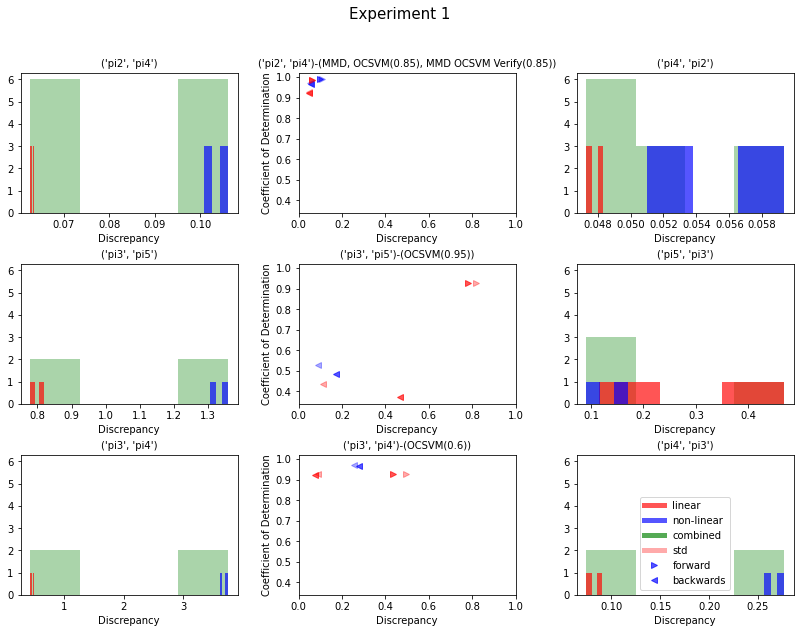

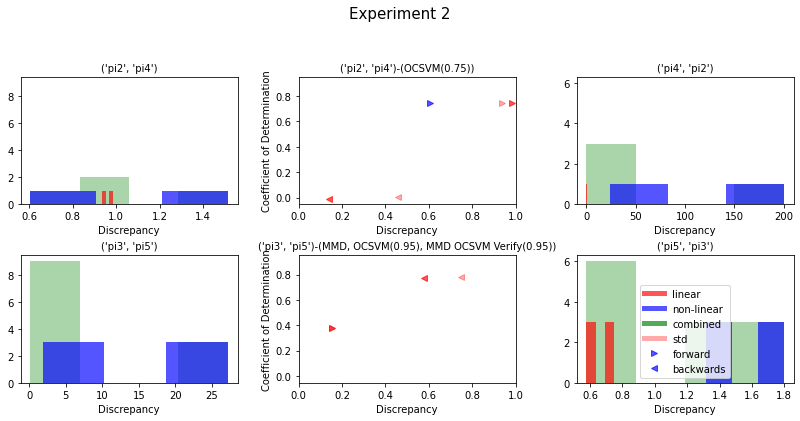

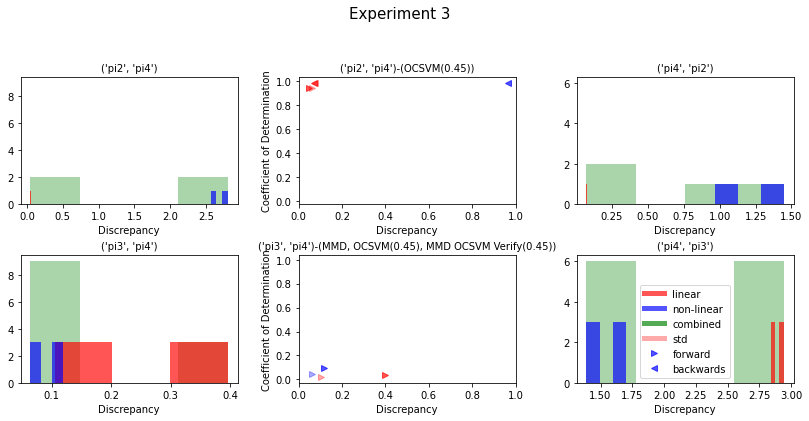

In [203]:
data = pd.read_csv(f"results/per method/sample_{1}.csv") 
stats = plot_r2_discrpenacy(data, omit_bad_pairs=True)

In [205]:
stats[1]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi4')",12.0,0.083241,0.021169,0.062691,0.063246,0.082106,0.102101,0.106061
"('pi4', 'pi2')",12.0,0.051495,0.004917,0.047317,0.048083,0.049678,0.053090,0.059306
"('pi3', 'pi5')",4.0,1.065284,0.308769,0.779333,0.808639,1.062077,1.318722,1.357647
"('pi5', 'pi3')",4.0,0.210883,0.174055,0.091384,0.108763,0.142485,0.244605,0.467181
"('pi3', 'pi4')",4.0,2.073396,1.856828,0.435819,0.481339,2.055343,3.647400,3.747078
"('pi4', 'pi3')",4.0,0.174406,0.106778,0.074338,0.086394,0.173467,0.261480,0.276350


In [206]:
stats[2]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi4')",4.0,1.010474,0.374577,0.606816,0.854644,0.961308,1.117137,1.512463
"('pi4', 'pi2')",4.0,56.052539,96.619941,0.138375,0.377248,12.013367,67.688658,200.045048
"('pi3', 'pi5')",12.0,7.318930,11.983652,0.153944,0.153995,0.982384,8.147319,27.157007
"('pi5', 'pi3')",12.0,1.110114,0.503168,0.577858,0.705892,1.032963,1.437185,1.796671


In [207]:
stats[3]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi4')",4.0,1.368379,1.519715,0.048612,0.058204,1.311645,2.621820,2.801614
"('pi4', 'pi2')",4.0,0.639609,0.682588,0.071681,0.074268,0.520352,1.085692,1.446051
"('pi3', 'pi4')",12.0,0.170893,0.137429,0.063933,0.094567,0.111765,0.188091,0.396107
"('pi4', 'pi3')",12.0,2.217730,0.712892,1.389112,1.623143,2.270180,2.864767,2.941445


In [80]:
samples = {}
for sample_id in range(1,5):
    sample = pd.read_csv(f"results/per method/sample_{i+1}.csv")
    experiment_data = {}
    for experiment in range(1,4):
        experiment_similar_pairs  = ""
        for method in methods:
            df = data.loc[(sample.experiment==experiment)&(data.method==method)]
            unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False)))
            similar_pairs = sort_similar_pairs(unique_pairs_df)
            experiment_similar_pairs += str(similar_pairs[::2])
        experiment_data[experiment] = experiment_similar_pairs
    samples[f"sample_{sample_id}"] = experiment_data

In [83]:
samples["sample_1"] == samples["sample_2"] == samples["sample_3"] == samples["sample_4"]       

True